# **Food Connect**

Food Connect is the platform where food lovers collectively share food experiences and can find new and exciting tastes. For users to get personalized restaurant recommendations we have tried to build a recommendation engine for the restaurants. Using this Machine Learning Model, we will be recommending restaurants based on the restaurants that the user has previously visited. We tried to provide a recommendation based on collaborative filtering. We experimented User-Item based collaborative filtering and Item-Item Based collaborative filtering Methods. 

## **Data Collection**:

**Data Narrative:** 

The Data that we used was an open-source version of Yelp_Review_Dataset provided by yelp.com. This dataset comprises reviews posted by all users for restaurants
We used yelp reviews dataset to recommend restaurants. This dataset contains full review text data including the user_id that wrote the review and the business_id the review is written for.



```
{
    // string, 22 character unique review id
    "review_id": "zdSx_SD6obEhz9VrW9uAWA",

    // string, 22 character unique user id, maps to the user in user.json
    "user_id": "Ha3iJu77CxlrFm-vQRs_8g",

    // string, 22 character business id, maps to business in business.json
    "business_id": "tnhfDv5Il8EaGSXZGiuQGg",

    // integer, star rating
    "stars": 4,

    // string, date formatted YYYY-MM-DD
    "date": "2016-03-09",

    // string, the review itself
    "text": "Great place to hang out after work: the prices are decent, and the ambience is fun. It's a bit loud, but very lively. The staff is friendly, and the food is good. They have a good selection of drinks.",

    // integer, number of useful votes received
    "useful": 0,

    // integer, number of funny votes received
    "funny": 0,

    // integer, number of cool votes received
    "cool": 0
}
```

# Installing Modules

In [1]:
!pip install surprise 
!pip install pandas
!pip install scipy
!pip install matplotlib

# Importing required Modules

In [2]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy


from surprise import *
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
import pickle

# Downloading the dataset


In [ ]:
!gdown --id 1VWnsm7M4YR1soOdEylHtI5nX2gDXBCIf

Downloading...
From: https://drive.google.com/uc?id=1VWnsm7M4YR1soOdEylHtI5nX2gDXBCIf
To: /content/yelp_academic_dataset_review.json
100% 6.94G/6.94G [02:17<00:00, 50.6MB/s]


# Data Preprocessing
The Yelp_Review_Dataset was a very huge dataset of  6 GB and it was very difficult to process it on our computer or even Google Collab Pro. For JSON to be used by the application the JSON data is supposed to be loaded onto memory. As we have 6GB of data to load, we were running out of memory.

To access this dataset and make it consumable we had to perform multiple pre-processing so that we don’t load the entire dataset into the memory.


## Reading dataset into chunks

Chunks of data using Pandas Library. Using this we extracted user information only. We extracted User_ID,  Restaurant_Id, and review stars from the dataset.

In [ ]:
filepath='/content/yelp_academic_dataset_review.json'
size = 100000
review = pd.read_json(filepath, lines=True,
                      dtype={'review_id':str,'user_id':str,
                             'business_id':str,'stars':int,
                             'date':str,'text':str,'useful':int,
                             'funny':int,'cool':int},
                      chunksize=size)

We removed missing values and to make the data consumable by machine learning models we converted user_ids into numbers using LabelEncoding from the SKlearn Library.

In [ ]:
chunk_list = []
x=True
count=0
df=pd.DataFrame(columns=['user_id','business_id','review_stars'])
try:
    for chunk_review in review:
        if True:
          df2=chunk_review
        chunk_review = chunk_review.drop(['review_id','useful','funny','cool','text','date'], axis=1)
        # Renaming column name to avoid conflict with business overall star rating
        chunk_review = chunk_review.rename(columns={'stars': 'review_stars'})
        


        df2=pd.DataFrame(chunk_review)
        df=df.append(df2)
except:
    pass

***The Above file that is generated consits of only required columns reducing the size significantly***

In [ ]:
# df.to_csv('my_file.csv')

## Downloading preprocessed data

In [ ]:
!gdown --id 1YDwM6lNsILUlUv5QOHRNeMRtiU6S6sPK

Downloading...
From: https://drive.google.com/uc?id=1YDwM6lNsILUlUv5QOHRNeMRtiU6S6sPK
To: /content/restaurants_dataset.csv
100% 94.1M/94.1M [00:01<00:00, 84.2MB/s]


## Reading Preprocessed Data

In [ ]:
dataset=pd.read_csv('/content/restaurants_dataset.csv')

In [ ]:
dataset=dataset.groupby('business_id').mean().reset_index()[['business_id','review_stars']]

In [ ]:
dataset

,Unnamed: 0,user_id,business_id,review_stars
0,0,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4
1,1,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4
2,2,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5
3,3,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2
4,4,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4
...,...,...,...,...
1699995,1699995,DCqK3QO1HiO_HMMAjGQWXg,gFwIUy6xBvG1M0VTfgZZFw,5
1699996,1699996,eQhK6dajPnWo4eQj6-Oy4g,Ag89Kt5lObftTZG7yPCMsQ,4
1699997,1699997,ae5PRyJfV6wJ8tD1IsR8fA,xLEyXF9LCaoUxi_MgW3Nrw,1
1699998,1699998,3bJ2zyYx2HbpxvedNmp8Gw,lFt7w7weA2pwp45Ulvaevg,1


In [ ]:
ratings_matrix = df.pivot_table(values='review_stars', index='user_id', columns='business_id', fill_value=0)
ratings_matrix

Averaging the rating as there are huge number of dataset and to process that data huge processing poweris required.

In [ ]:
dataset['user_id'] = range(1, len(dataset) + 1)

In [ ]:
dataset

,business_id,review_stars,user_id
0,--0r8K_AQ4FZfLsX3ZYRDA,5.000000,1
1,--164t1nclzzmca7eDiJMw,3.877551,2
2,--4INAzazK6omgf3mY3dfw,3.500000,3
3,--DzGwfuJH12DjYz95VW0Q,2.266667,4
4,--JuLhLvq3gyjNnXT9Q95w,5.000000,5
...,...,...,...
32113,zzA7GQUwsLoy5uTXolJg2A,4.230769,32114
32114,zzAm2gQYRhGxlRuFpKX1SA,4.166667,32115
32115,zzR3b97lAXvMqcppMAYRuw,2.714286,32116
32116,zz_Pq7W4GdzwtayGgWZm8g,2.600000,32117


In [ ]:
dataset=dataset[['user_id','business_id','review_stars']]

In [ ]:
dataset.columns=['user_id','item_id','stars']

In [ ]:
dataset

,user_id,item_id,stars
0,1,--0r8K_AQ4FZfLsX3ZYRDA,5.000000
1,2,--164t1nclzzmca7eDiJMw,3.877551
2,3,--4INAzazK6omgf3mY3dfw,3.500000
3,4,--DzGwfuJH12DjYz95VW0Q,2.266667
4,5,--JuLhLvq3gyjNnXT9Q95w,5.000000
...,...,...,...
32113,32114,zzA7GQUwsLoy5uTXolJg2A,4.230769
32114,32115,zzAm2gQYRhGxlRuFpKX1SA,4.166667
32115,32116,zzR3b97lAXvMqcppMAYRuw,2.714286
32116,32117,zz_Pq7W4GdzwtayGgWZm8g,2.600000


In [ ]:
df_new=dataset
df_new.columns=['userID','itemID','rating']

In [ ]:
df_new

,userID,itemID,rating
0,1,--0r8K_AQ4FZfLsX3ZYRDA,5.000000
1,2,--164t1nclzzmca7eDiJMw,3.877551
2,3,--4INAzazK6omgf3mY3dfw,3.500000
3,4,--DzGwfuJH12DjYz95VW0Q,2.266667
4,5,--JuLhLvq3gyjNnXT9Q95w,5.000000
...,...,...,...
32113,32114,zzA7GQUwsLoy5uTXolJg2A,4.230769
32114,32115,zzAm2gQYRhGxlRuFpKX1SA,4.166667
32115,32116,zzR3b97lAXvMqcppMAYRuw,2.714286
32116,32117,zz_Pq7W4GdzwtayGgWZm8g,2.600000


# Model Training and Evaluation

## User-Item Collaborative Filtering

The Data was finally reduced to 17,00,000 reviews User-Item Collaborative Filtering. As the user that we have in our application is not going to be a part of the current dataset, we decided to take only the mean of the reviews of restaurants. Subsequently making the data reduction to 32000 restaurants ratings. Using this we have used Surprise Library which is used to build a recommendation engine. We Split the input data into 80% Train and 20% Testing datasets. Then using the surprise libraries Reader module converted the data into Surprise trainset. Later tried Various algorithms 

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new,reader)

In [ ]:
trainset, testset = train_test_split(data, test_size=0.3,random_state=10)

In [ ]:
acuuracy_table={}

## NormalPredictor

In [ ]:
algo = NormalPredictor( )
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy_model=round(float(str(accuracy.rmse(test_pred, verbose=True))[0:]),4)
accuracy_model
acuuracy_table['NormalPredictor']=accuracy_model

RMSE: 1.2869


The Root mean square Error of NormalPredictor is 1.2869

# BaselineOnly

In [ ]:
algo = BaselineOnly()
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy_model=round(float(str(accuracy.rmse(test_pred, verbose=True))[0:]),4)
accuracy_model
acuuracy_table['BaselineOnly']=accuracy_model

Estimating biases using als...
RMSE: 0.9336


The Root mean square Error of BaselineOnly is 0.9336

# Singular Value Decomposition 

In [ ]:
algo = SVD()
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy_model=round(float(str(accuracy.rmse(test_pred, verbose=True))[0:]),4)
accuracy_model
acuuracy_table['SVD']=accuracy_model

RMSE: 0.9336


The Root mean square Error of BaselineOnly is 0.9336

# SVDpp

In [ ]:
algo =SVDpp()
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy_model=round(float(str(accuracy.rmse(test_pred, verbose=True))[0:]),4)
accuracy_model
acuuracy_table['SVDpp']=accuracy_model

RMSE: 0.9336


The Root mean square Error of BaselineOnly is 0.9336

# Non-Negative Matrix Factorization

In [ ]:
algo =NMF()
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy_model=round(float(str(accuracy.rmse(test_pred, verbose=True))[0:]),4)
accuracy_model
acuuracy_table['NMF']=accuracy_model

RMSE: 0.9336


The Root mean square Error of BaselineOnly is 0.9336

# CoClustering

In [ ]:
algo =CoClustering()
algo.fit(trainset)
test_pred = algo.test(testset)
accuracy_model=round(float(str(accuracy.rmse(test_pred, verbose=True))[0:]),4)
accuracy_model
acuuracy_table['CoClustering']=accuracy_model

RMSE: 0.9336


The Root mean square Error of BaselineOnly is 0.9336

### The Accuracy of models is

In [ ]:
acuuracy_table

{'BaselineOnly': 0.9336,
 'CoClustering': 0.9336,
 'NMF': 0.9336,
 'NormalPredictor': 1.2869,
 'SVDpp': 0.9336}

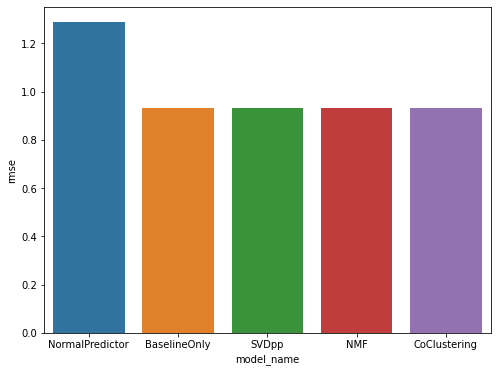

In [ ]:
accuracy_x=pd.DataFrame.from_dict(acuuracy_table,orient='index').reset_index()
accuracy_x.columns=['model_name','rmse']

plt.figure(figsize=(8, 6))
ax = sns.barplot(data=accuracy_x, x='model_name', y='rmse')

After using multiple algorithms it can be seen that surprisingly 4 out of 5 models are performing with rmse of 0.9336



---




# Item - Item Collaborative Filetering

In this type of recommendation system input is a restaurant(ITEM) and recommendation is a List of recommended restaurants(ITEM).

## Methodology

For this we need to convert the Dataset into a different format to be able to consume and generate Recommendations

The Following is the input dataset

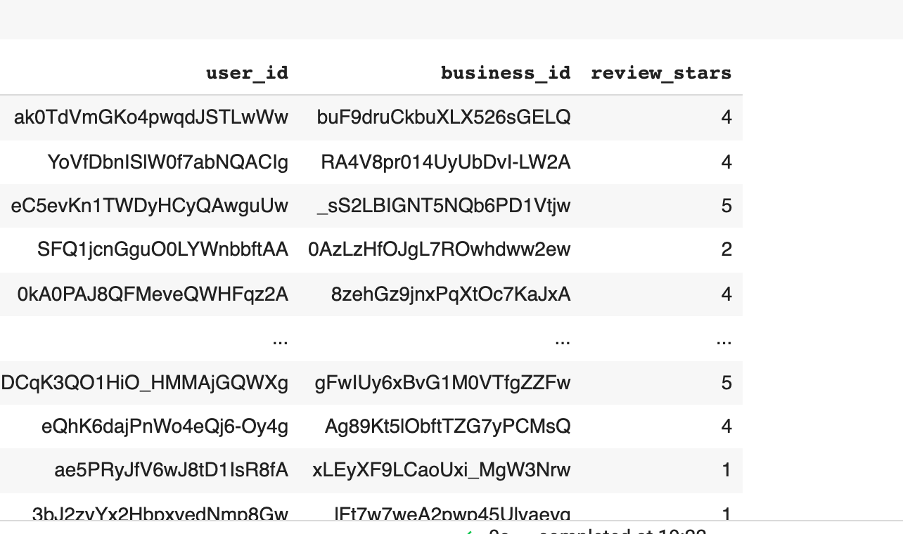

The dataset it to be pivoted into the following format

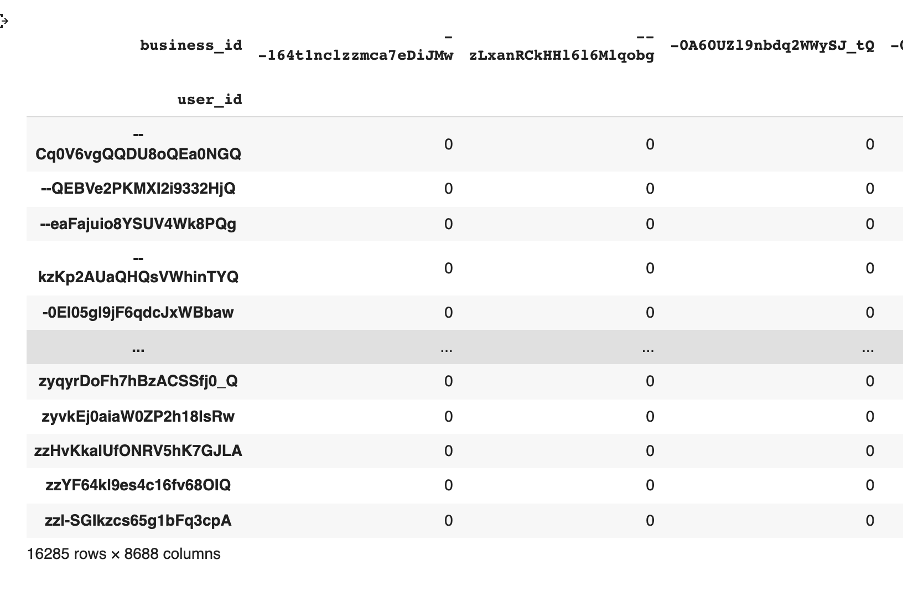

### Encoding the business_id into simple numbers

In [ ]:
le = preprocessing.LabelEncoder()

In [ ]:
dataset['le_item_id']=le.fit_transform(dataset.item_id)

In [ ]:
dataset

In [ ]:
dataset=dataset[['user_id','le_item_id','stars']]
dataset.columns=['user_id','item_id','stars']

## Pivoting the input Dataset

In [ ]:
n_users = dataset.user_id.unique().shape[0]
n_items = dataset.item_id.unique().shape[0]
# n_items = dataset['item_id'].max()
A = np.zeros((n_users,n_items))
for line in dataset.itertuples():
    A[line[1]-1,line[2]-1] = line[3]
print("Original rating matrix : ",A)

The Converted pivoted matrix is obviously going to have too many zeroes as  users might not have visited majority of restaurants. Hence converting the above matrix into sparse matrix can imporove processing 

### Converting into Sparse Matrix

In [ ]:
csr_sample = csr_matrix(A)
print(csr_sample)

### KNN Model Training

In [ ]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=3, n_jobs=-1)
knn.fit(csr_sample)

## Saving the model components
These Model artifcats will be used in inference

In [ ]:
scipy.sparse.save_npz('sparse_matrix.npz', csr_sample)
pickle.dump(knn,open('knn', 'wb'))
pickle.dump(le,open('le', 'wb'))

## Loading the models

In [ ]:
knn=pickle.load(open('knn', 'rb'))
le=pickle.load(open('le', 'rb'))
csr_sample=scipy.sparse.load_npz('sparse_matrix.npz')

# Using the model for recommendation



1.   Convert the restaurant information into Label Encoded value
2.   Use the encoded value in KNN ML Model to get similar restaurants
3.   Inverse transform the resultant restaurant into restaurant id



In [ ]:
def get_recommendations(filter_input,n=5):
    filter1=le.transform(filter_input)
    distances1=[]
    indices1=[]
    for i in filter1:
        distances , indices = knn.kneighbors(csr_sample[i],n_neighbors=10)
        indices = indices.flatten()
        indices= indices[1:]
        indices1.extend(indices)
        recs=list(set(le.inverse_transform(indices1)))
    return recs[0:n]

In [ ]:
get_recommendations(['--0r8K_AQ4FZfLsX3ZYRDA'],5)